In [4]:
using PyPlot
using LinearAlgebra
using JuMP
using Ipopt 
using Statistics
using RandomMatrices
using BirkhoffDecomposition
using Permutations, RollingFunctions

In [5]:
function rowsum(A) #Returns a column vector containing the row sums of square matrix A
    m = size(A,1)
    rowsum = zeros(m,1)
    for i in 1:m
        rowsum[i] = sum(A[i,:])
    end
    return rowsum
end
####################################
function colsum(A) #Returns a column vector containing the column sums of square matrix A
    n = size(A,2)
    colsum = zeros(n,1)
    for i in 1:n
        colsum[i] = sum(A[:,i])
    end
    return colsum
end
####################################
function rs_ize(A) #Returns a row stochastic matrix, given a nonnegative matrix A
    rsA = rowsum(A)
    A = inv(diagm(vec(rsA)))*A  #A is row stochastic
    return A
end
#######################################
# Φ cal with sigmoid
function Φ(dif,F,W)
    sig1 = 1-(1+exp(F*(dif+W)))^(-1)
    sig2 = (1+exp(F*(dif-W))).^(-1)
    return sig1 .* sig2
end
########################################
function HK_update(A,x_os_up,F,W)
    N_a = size(A,2)
    xup = zeros(N_a,1)
    confi = 0;
    update = 0;
    for i in 1:N_a
        confi = sum(A[i,j]*Φ(x_os_up[j,1]-x_os_up[i,1],F,W) for j in 1:N_a)
        update = sum(A[i,j]*(Φ(x_os_up[j,1]-x_os_up[i,1],F,W)*(x_os_up[j,1]-x_os_up[i,1])) for j in 1:N_a)
        xup[i,1] = x_os_up[i,1] + (1/confi)*(update)
        update = 0
        confi = 0
    end 
    return xup
end
########################################
#Projection of vector x_os onto the hypercube [-1,1]^n
function hyp_proj(x_os)
    for i in 1:length(x_os)
        if x_os[i] >= 1
            x_os[i] = 1
        end
        if x_os[i] <= -1
            x_os[i] = -1
        end
    end
    return x_os
end
########################################
function mov_avg(data,win)
    x_int = zeros(size(data))
    for k in 1:size(data,1) 
        x_int[k,:] = runmean(data[k,:], win)
    end
    return x_int
end
##############################################################################################################
#Gauss-Seidel agent updates, one player at a time
#COD = controlled opinion dynamics, GS = Gauss-Seidel information flow; one player updates at a time
function COD_OSA_GS(x_init,targets,γ,K_f,A,B,Θ,F,W,proj_flag,perm_flag, model)
#Initialize arrays
    N_a = length(x_init) #Number of agents
    N_p = size(targets,2) #Number of players: player_targets is an n by p matrix of targets for the p players
    x_os = zeros(N_a,K_f + 1)  #Column j: opinions of N_a agents at instant j, Row i: time evolution of agent i's opinion
    u_os = zeros(N_p,K_f)      #Column j: controls of N_p players at instant j, Row i: time evolution of player i's controls
    x_os[:,1] = x_init         #Initial states (opinions) of each agent
    x_temp = zeros(length(x_init)) #temporary state, as each agent updates and passes on to the next agent
    for k in 1:K_f #Time loop
        x_temp = x_os[:,k] #Temp. state set to current state
        if perm_flag == 1
            p_reord = RandomPermutation(N_p)
        else
            p_reord = 1:1:N_p
        end
        for p in 1:N_p #player loop
            if model == 1
                x_temp, u_os[p,k] = COD_OSA_1p_update(x_temp,targets[:,p_reord[p]],γ[p_reord[p]],A,B[:,p_reord[p]])  #This is executed N_p times
            elseif model == 2
                x_temp, u_os[p,k] = COD_OSA_1p_update_FJ(x_temp,targets[:,p_reord[p]],γ[p_reord[p]],A,B[:,p_reord[p]],Θ,x_os[:,1])  #This is executed N_p times
            elseif model == 3
                x_temp, u_os[p,k] = COD_OSA_1p_update_HK(x_temp,targets[:,p_reord[p]],γ[p_reord[p]],A,B[:,p_reord[p]],F,W)  #This is executed N_p times
            end
            if proj_flag == 1
                x_temp = hyp_proj(x_temp) #If the projection flag is set to one, each new x_temp is cut to size by projection
            end
        end
        x_os[:,k+1] = x_temp #Here the N_p times updated temp state becomes the current state at iteration k+1
    end
    return x_os, u_os
end
###############################################################################################################
function COD_OSA_1p_update(x_os,targ,γ,A,b)
#Initialize arrays
    N_a = length(x_os) #Number of agents
    S = Model(Ipopt.Optimizer)
    set_optimizer_attributes(S, "print_level" => 0 )
    #Define the optimization variables
    @variable(S, v) #v is the scalar value of the control for player p
    @variable(S, xn[1:N_a]) #xn is the new state of agent influenced by p
    #Define the dynamics as an equality constraint
    @constraint(S, xn .== A*x_os + b*v)
    #Define the objective function for agent p
    @objective(S, Min, sum((xn - targ).^2) + γ*v*v) #****************************************
    optimize!(S)
    #Retrieve optimal values for current control
    #u_os = JuMP.value.(S[:v])
    x_os = JuMP.value.(S[:xn]) #Next state (without projection)
    v = JuMP.value.(S[:v])
    return x_os, v
end
###################################################################################################################
function COD_OSA_1p_update_FJ(x_os,targ,γ,A,b,Θ,x_init)
#Initialize arrays
    N_a = length(x_os) #Number of agents
    S = Model(Ipopt.Optimizer)
    set_optimizer_attributes(S, "print_level" => 0 )
    #Define the optimization variables
    @variable(S, v) #v is the scalar value of the control for player p
    @variable(S, xn[1:N_a]) #xn is the new state of agent influenced by p
    #Define the dynamics as an equality constraint
    @constraint(S, xn .== A*x_os + Θ*x_init + b*v)
    #Define the objective function for agent p
    @objective(S, Min, sum((xn - targ).^2) + γ*v*v) #****************************************
    optimize!(S)
    #Retrieve optimal values for current control
    #u_os = JuMP.value.(S[:v])
    x_os = JuMP.value.(S[:xn]) #Next state (without projection)
    v = JuMP.value.(S[:v]) 
    return x_os, v
end
######################################################################################################################
function COD_OSA_1p_update_HK(x_os,targ,γ,A,b,F,W)
#Initialize arrays
    N_a = length(x_os) #Number of agents
    S = Model(Ipopt.Optimizer)
    set_optimizer_attributes(S, "print_level" => 0 )
    #Define the optimization variables
    @variable(S, v) #v is the scalar value of the control for player p
    @variable(S, xn[1:N_a]) #xn is the new state of agent influenced by p
    #Define the dynamics as an equality constraint
    @constraint(S, xn .== HK_update(A,x_os,F,W) + b*v)
    #Define the objective function for agent p
    @objective(S, Min, sum((xn - targ).^2) + γ*v*v) #****************************************
    optimize!(S)
    #Retrieve optimal values for current control
    #u_os = JuMP.value.(S[:v])
    x_os = JuMP.value.(S[:xn]) #Next state (without projection)
    v = JuMP.value.(S[:v])
    return x_os, v
end
##############################################################################################
function plot_targ_5a3p(x_plot, target, T, perm_flag, model, save)
    figure(figsize=(6,6))
    grid()
    if model == 1
        for i in 1:5
            plot(x_plot[i,1:T],".-")
        end
    elseif model == 2
        for i in 6:10
            plot(x_plot[i,1:T],".-")
        end
    elseif model == 3
        for i in 11:15
            plot(x_plot[i,1:T],".-")
        end
    end
    plot(target[1].*ones(T,1),"--",color = "blue");
    plot(target[2].*ones(T,1),"--",color = "darkorange");
    plot(target[3].*ones(T,1),"--",color = "green");
    xlabel("Time")
    ylabel("Opinions \$x_i\$, \$i=1,...,5\$")
    legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5",L"goal_1",L"goal_2", L"goal_3"],loc="right")
    
    if model == 1
        if perm_flag == 0
            title("Time plots of opinion: dGc, Gauss-Seidel procedure")
            if save == 1
                savefig("DeGroot_GS_5players_noperm.png")
                savefig("DeGroot_GS_5players_noperm.eps")
            end
        elseif perm_flag == 1
            title("Time plots of opinion: dGc, RGS procedure")
            if save == 1
                savefig("DeGroot_GS_5players_perm.png")
                savefig("DeGroot_GS_5players_perm.eps")
            end
        end
    elseif model == 2
        if perm_flag == 0
            title("Time plots of opinion: FJc, Gauss-Seidel procedure")
            if save == 1
                savefig("FJ_GS_5players_noperm.png")
                savefig("FJ_GS_5players_noperm.eps")
            end
        elseif perm_flag == 1
            title("Time plots of opinion: FJc, RGS procedure")
            if save == 1
                savefig("FJ_GS_5players_perm.png")
                savefig("FJ_GS_5players_perm.eps")
            end
        end
    elseif model == 3
        if perm_flag == 0
            title("Time plots of opinion: HKc, Gauss-Seidel procedure")
            if save == 1
                savefig("HK_GS_5players_noperm.png")
                savefig("HK_GS_5players_noperm.eps")
            end
        elseif perm_flag == 1
            title("Time plots of opinion: HKc, RGS procedure")
            if save == 1
                savefig("HK_GS_5players_perm.png")
                savefig("HK_GS_5players_perm.eps")
            end
        end
    end 
end
###############################################################################################
function plot_targ_10a(x_plot, T, perm_flag, model, save)
    figure(figsize=(6,6))
    grid()
    if model == 1
        for i in 1:10
            plot(x_plot[i,1:T],".-")
        end
    elseif model == 2
        for i in 11:20
            plot(x_plot[i,1:T],".-")
        end
    elseif model == 3
        for i in 21:30
            plot(x_plot[i,1:T],".-")
        end
    end
    xlabel("Time")
    ylabel("Opinions \$x_i\$")
    legend([L"x_1",L"x_2", L"x_3", L"x_4", L"x_5", L"x_6", L"x_7", L"x_8", L"x_9", L"x_{10}"],loc="right")
    
    if model == 1
        if perm_flag == 0
            title("Time plots of opinion: dGc, Gauss-Seidel procedure, no perm")
            if save == 1
                savefig("DeGroot_GS_10a_noperm.png")
                savefig("DeGroot_GS_10a_noperm.eps")
            end
        elseif perm_flag == 1
            title("Time plots of opinion: dGc, RGS procedure")
            if save == 1
                savefig("DeGroot_GS_10a_perm.png")
                savefig("DeGroot_GS_10a_perm.eps")
            end
        end
    elseif model == 2
        if perm_flag == 0
            title("Time plots of opinion: FJc, Gauss-Seidel procedure, no perm")
            if save == 1
                savefig("FJ_GS_10a_noperm.png")
                savefig("FJ_GS_10a_noperm.eps")
            end
        elseif perm_flag == 1
            title("Time plots of opinion: FJc, RGS procedure")
            if save == 1
                savefig("FJ_GS_10a_perm.png")
                savefig("FJ_GS_10a_perm.eps")
            end
        end
    elseif model == 3
        if perm_flag == 0
            title("Time plots of opinion: HKc, Gauss-Seidel procedure, no perm")
            if save == 1
                savefig("HK_GS_10a_noperm.png")
                savefig("HK_GS_10a_noperm.eps")
            end
        elseif perm_flag == 1
            title("Time plots of opinion: HKc, RGS procedure")
            if save == 1
                savefig("HK_GS_10a_perm.png")
                savefig("HK_GS_10a_perm.eps")
            end
        end
    end 
end

plot_targ_10a (generic function with 1 method)

# 5 agents, with 3 players

In [ ]:
#Agents initial conditions
N_a_1 =  10 #number of agents
#x_init_1 = rand(N_a_1) 
#x_init_1 = 0.5*zeros(N_a_1);
x_init_1 = [0.5;0.7; 0.4; 0.4; 0.8; 0.7; 0.9; 0.6; 0.3; 0.5]

#Players targets
#N_p_1 = 3
#x1_hat_1 = 1.5
#x2_hat_1 = 0.2
#x3_hat_1 = -1.2
#target = [x1_hat_1; x2_hat_1; x3_hat_1]
#target = [x1_hat_1; x2_hat_1; x3_hat_1; x4_hat_1]
#=
targets_1 = [x1_hat_1    0        0          ; #first agent
             0      x2_hat_1    0          ; 
             0       0       x3_hat_1      ;
             0       0        0          ;
             0        0        0          ] #last agent
=#
#=
targets_1 = [x1_hat_1    0        0     0; #first agent
             0      x2_hat_1    0       0; 
             0       0       x3_hat_1   0;
             0       0        0         x4_hat_1 ;
             0        0        0        0  ] #last agent
=#
####################################################
# Mazalov
#=
x1_hat_1 = 0.5
x2_hat_1 = 0.7
x3_hat_1 = 0.2
x4_hat_1 = 0.3
target = [x1_hat_1; x2_hat_1; x3_hat_1; x4_hat_1]
p1 = [x1_hat_1;0;0;0;0;0;0;0;0;0]
p2 = [0;0;0;x2_hat_1;0;0;0;0;0;0]
p3 = [0;0;0;0;0;x3_hat_1;0;0;0;0]
p4 = [0;0;0;0;0;0;0;0;x4_hat_1;0]

targets_1 = [p1 p2 p3 p4]
=#
######################################################
#γ_1 = [0.01; 0.01; 0.01];
γ_1 = [0.01; 0.01; 0.01; 0.01];

#Dynamics
#DeGroot model
A_1 = 1/N_a_1.*ones(N_a_1,N_a_1);
B_1 = [1 0 0 0; 0 0 0 0; 0 0 0 0; 0 1 0 0; 0 0 0 0; 0 0 1 0;  0 0 0 0; 0 0 0 0; 0 0 0 1; 0 0 0 0];
#A_1 = [0.1 0.4 0.2 0.1 0.2; 0.5 0.1 0.1 0.1 0.2; 0.3 0.1 0.4 0.1 0.1; 0.1 0.1 0.3 0.4 0.1; 0.2 0.05 0.1 0.45 0.2];
#B_1 = [0.8 0 0; 0 0.8 0; 0 0 0.8; 0 0 0; 0 0 0];
#B_1 = [0.8 0 0 0; 0 0.8 0 0; 0 0 0.8 0; 0 0 0 0.8; 0 0 0 0];

#Friedkin-Johnsen model
#Θ_1 = diagm([0,0,0,0.6,0.8])
Θ_1 = diagm([0.8,0.2,0.4,0,0.8,0,0.3,0.4,0.5,0])
A_FJ_1 = (I(N_a_1)-Θ_1)*A_1;

#Hegselmann-Krause model
F_1 = 90;
W_1 = 0.4

A_HK_1 = ones(N_a_1,N_a_1)

K_f_1 = 60; #horizon
T = K_f_1;

In [ ]:
p_flag = 0; #Projection flag
perm_flag = 1; #Perm flag
#last digit is model: 1 - DeGroot; 2 - FJ; 3 - HK
x_os_1, u_os_1 = COD_OSA_GS(x_init_1,targets_1,γ_1,K_f_1,A_1,B_1,Θ_1,F_1,W_1,p_flag,perm_flag,1);
x_os_1fj, u_os_1fj = COD_OSA_GS(x_init_1,targets_1,γ_1,K_f_1,A_1,B_1,Θ_1,F_1,W_1,p_flag,perm_flag,2);
x_os_1hk, u_os_1hk = COD_OSA_GS(x_init_1,targets_1,γ_1,K_f_1,A_1,B_1,Θ_1,F_1,W_1,p_flag,perm_flag,3);
x_os = [x_os_1;x_os_1fj;x_os_1hk];

In [ ]:
#x_plot = mov_avg(x_os_1fj, 1)

model = 1  # model: 1 - DeGroot; 2 - FJ; 3 - HK
save = 0
plot_targ_5a3p(x_os, target, T, perm_flag, model, save)

In [33]:
#Initial Conditions
x_init_2 = [1;0.7;1;0.9;1;-1;-0.8;-1;-0.8;-1]
#Players targets
N_p_2 = 2
x1_hat_2 = -2
x2_hat_2 = 2

targets_2 = [x1_hat_2  x2_hat_2;
             x1_hat_2     0;
             x1_hat_2     0;  
             x1_hat_2     0;  
             x1_hat_2  x2_hat_2;
               0       x2_hat_2;
               0       x2_hat_2;
               0       x2_hat_2;
               0       x2_hat_2;
             x1_hat_2  x2_hat_2]     
γ_2 = [0.01;0.01]
#println("Gamma = ", γ[1:N_p_s])

#Dynamics
B_2 = [1 1; 1 0; 1 0; 1 0; 1 1; 0 1; 0 1; 0 1; 0 1; 1 1]

A_t = [80 55 30 75 0 0 0 0 0 0;
       55  54 63 0 64 0 0 0 0 0 ;
       60 40 65 74 67 0 0 0 0 0 ;
       75 0 55 25 85 34 12 0 0 0 ;
       0 64 38 85 85 0 0 0 0 23 ;
       0 0 0 0 0 85 82 62 84 0 ;
       20 0 0 0 40 82 47 50 94 55 ;
       0 0 0 0 0 62 0 61 82 47 ;
       0 0 0 0 0 53 58 47 55 68 ;
       0 0 0 6 0 0 55 47 69 41]
N_a_2 = size(A_t,2)
A_2 = rs_ize(A_t)

#Friedkin-Johsen model
Θ_2 = diagm([0.5,0.3,0,0.8,0,0.1,0,0.3,0,0.6])
A_FJ_2 = (I(N_a_2)-Θ_2)*A_2;

#Hegselmann-Krause model
F_2 = 90;
W_2 = 1.6;

A_HK_2 = [1 1 1 1 0 0 0 0 0 0;
          1 1 1 0 1 0 0 0 0 0;
          1 1 1 1 1 0 0 0 0 0;
          1 0 1 1 1 1 1 0 0 0;
          0 1 1 1 1 0 0 0 0 1;
          0 0 0 0 0 1 1 1 1 0;
          1 0 0 0 1 1 1 1 1 1;
          0 0 0 0 0 1 0 1 1 1;
          0 0 0 0 0 1 1 1 1 1;
          0 0 0 1 0 0 1 1 1 1]

K_f_2 = 35; #horizon
T = K_f_2;

In [49]:
P = zeros(N_a_2,N_a_2)
G = zeros(N_a_2,1)
Acl = ones(N_a_2,N_a_2)
P_g = zeros(N_a_2,N_a_2)
for i in 1:size(B_2,2)
    u = B_2[:,i]
    P = (1/(u'*u + γ_2[i]))*(u*u')
    Acl = Acl * ((I(N_a_2)-P)*A_2)
    #G = G + ((1/(u'*u + γ[i]))*(u*u'))*targets[:,i]
end
P_1 = (1/(B_2[:,1]'*B_2[:,1] + γ_2[1]))*(B_2[:,1]*B_2[:,1]');
P_2 = (1/(B_2[:,2]'*B_2[:,2] + γ_2[2]))*(B_2[:,2]*B_2[:,2]');
Acl_1 = ((I(N_a_2)-P_1)*A_2)*((I(N_a_2)-P_2)*A_2)
G = (I(N_a_2)-P_1)*A_2*P_1*targets_2[:,1]+P_2*targets_2[:,2]

xeq = (I(N_a_2)-Acl)\G
radius = maximum(abs.(Acl))
#Acl = (I(N_a)-P)*A; 
xeq

10-element Vector{Float64}:
 3.0317847963899514
 1.0346378634370272
 1.034637863437027
 1.3557809466433386
 3.031784796389951
 3.3491403398897526
 2.7573431633626586
 2.9767451255644217
 2.865959875539115
 4.597981807487663

In [50]:
Acl-Acl_1

10×10 Matrix{Float64}:
 -0.291086    -0.249764   -0.177749   …  0.195646  0.25251   0.131169
 -0.194077    -0.293215   -0.16392       0.218852  0.285381  0.130414
 -0.216514    -0.249513   -0.164537      0.206739  0.268224  0.123844
 -0.149069    -0.229686   -0.102971      0.219233  0.284865  0.148212
 -0.169687    -0.231503   -0.164875      0.183286  0.234135  0.0979499
 -0.129324    -0.155805   -0.0876636  …  0.143336  0.180215  0.0887587
 -0.139246    -0.189983   -0.107387      0.163975  0.213266  0.0932526
 -0.11582     -0.155805   -0.0876636     0.121759  0.166032  0.0688153
 -0.12646     -0.155805   -0.0876636     0.134367  0.163595  0.0744516
 -0.00523878  -0.0639237   0.0295908     0.104245  0.122685  0.0194792

# No Permutation

In [31]:
p_flag = 0; #Projection flag
perm_flag = 0; #Perm flag
#last digit is model: 1 - DeGroot; 2 - FJ; 3 - HK
x_os_2, u_os_2 = COD_OSA_GS(x_init_2,targets_2,γ_2,K_f_2,A_2,B_2,Θ_2,F_2,W_2,p_flag,perm_flag,1);
x_os_2fj, u_os_2fj = COD_OSA_GS(x_init_2,targets_2,γ_2,K_f_2,A_2,B_2,Θ_2,F_2,W_2,p_flag,perm_flag,2);
x_os_2hk, u_os_2hk = COD_OSA_GS(x_init_2,targets_2,γ_2,K_f_2,A_2,B_2,Θ_2,F_2,W_2,p_flag,perm_flag,3);
x_os2 = [x_os_2;x_os_2fj;x_os_2hk];

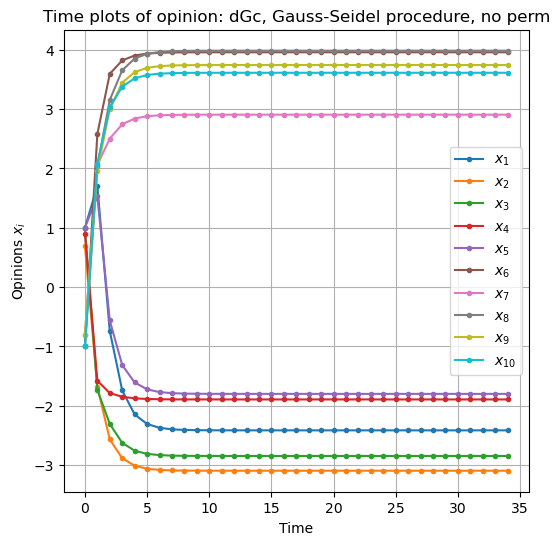

In [17]:
#x_plot = mov_avg(x_os_1fj, 1)

model = 1  # model: 1 - DeGroot; 2 - FJ; 3 - HK
save = 0
plot_targ_10a(x_os2, T, perm_flag, model, save)